<a href="https://colab.research.google.com/github/Vignesh-397/ObjecetDetection_Single_Shot_Multibox_Detection/blob/main/SSD_Updated_mAP_CV_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install roboflow
from roboflow import Roboflow

# Connect to Roboflow and download the dataset
rf = Roboflow(api_key="ZC9YX5kSm5wFRKdnv9m2")
project = rf.workspace("demo-tlvzf").project("mp-n2wrn")
dataset = project.version(4).download("yolov9", location="/content/yolov9_data/").location


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 2.1 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to /content/yolov9_data/ in yolov9:: 100%|██████████| 1212/1212 [00:00<00:00, 1798.55it/s]


In [2]:
import os
import shutil

# Base path to your dataset
base_path = "/content/yolov9_data/"

# Directories to combine
data_types = ["train", "test", "valid"]
sub_dirs = ["images", "labels"]

# Combined dataset directories
combined_path = os.path.join(base_path, "combined")
combined_images_path = os.path.join(combined_path, "images")
combined_labels_path = os.path.join(combined_path, "labels")

# Create directories for the combined dataset
os.makedirs(combined_images_path, exist_ok=True)
os.makedirs(combined_labels_path, exist_ok=True)

# Combine files
for data_type in data_types:
    for sub_dir in sub_dirs:
        source_dir = os.path.join(base_path, data_type, sub_dir)
        dest_dir = combined_images_path if sub_dir == "images" else combined_labels_path

        # Copy all files from source_dir to dest_dir
        for file_name in os.listdir(source_dir):
            source_file = os.path.join(source_dir, file_name)
            dest_file = os.path.join(dest_dir, file_name)
            shutil.copy(source_file, dest_file)

print(f"Combined dataset created at {combined_path}")


Combined dataset created at /content/yolov9_data/combined


In [3]:
# Install dependencies
!pip install roboflow torch torchvision matplotlib opencv-python albumentations tabulate

In [4]:
# Import Libraries
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from xml.etree import ElementTree as ET
from xml.dom import minidom
from torchvision.transforms import functional as F
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from torchvision.models.detection import SSD300_VGG16_Weights
from collections import defaultdict
from torchvision.ops import box_iou
from torch.optim import AdamW
from tabulate import tabulate
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import KFold

A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


In [13]:
def create_pascal_voc_annotation(image_path, label_path, output_dir, class_names):
    image = cv2.imread(image_path)
    h, w, c = image.shape

    # Parse YOLO annotations
    with open(label_path, 'r') as file:
        lines = file.readlines()

    annotation = ET.Element("annotation")
    folder = ET.SubElement(annotation, "folder").text = os.path.basename(os.path.dirname(image_path))
    filename = ET.SubElement(annotation, "filename").text = os.path.basename(image_path)
    size = ET.SubElement(annotation, "size")
    ET.SubElement(size, "width").text = str(w)
    ET.SubElement(size, "height").text = str(h)
    ET.SubElement(size, "depth").text = str(c)

    for line in lines:
        class_id, x_center, y_center, box_width, box_height = map(float, line.split())
        x_min = int((x_center - box_width / 2) * w)
        y_min = int((y_center - box_height / 2) * h)
        x_max = int((x_center + box_width / 2) * w)
        y_max = int((y_center + box_height / 2) * h)

        obj = ET.SubElement(annotation, "object")
        ET.SubElement(obj, "name").text = class_names[int(class_id)]
        bndbox = ET.SubElement(obj, "bndbox")
        ET.SubElement(bndbox, "xmin").text = str(x_min)
        ET.SubElement(bndbox, "ymin").text = str(y_min)
        ET.SubElement(bndbox, "xmax").text = str(x_max)
        ET.SubElement(bndbox, "ymax").text = str(y_max)

    # Convert to a pretty XML string
    xml_str = minidom.parseString(ET.tostring(annotation)).toprettyxml(indent="   ")
    xml_output_path = os.path.join(output_dir, os.path.basename(label_path).replace(".txt", ".xml"))

    with open(xml_output_path, "w") as xml_file:
        xml_file.write(xml_str)

# Define Dataset Paths
base_path = "/content/yolov9_data/"
train_image_dir = os.path.join(base_path, "combined/images")
train_label_dir = os.path.join(base_path, "combined/labels")
train_output_dir = os.path.join(base_path, "combined/xml_annotations")
os.makedirs(train_output_dir, exist_ok=True)

class_names = ["Background", "Cardboard", "E-waste", "Fabric", "Metal", "Organic", "Paper", "Plastic"]

for label_file in os.listdir(train_label_dir):
    create_pascal_voc_annotation(
        os.path.join(train_image_dir, label_file.replace(".txt", ".jpg")),
        os.path.join(train_label_dir, label_file),
        train_output_dir,
        class_names,
    )


In [14]:
test_image_dir = os.path.join(base_path, "test/images")
test_label_dir = os.path.join(base_path, "test/labels")
test_output_dir = os.path.join(base_path, "test/xml_annotations")
os.makedirs(test_output_dir, exist_ok=True)

for label_file in os.listdir(test_label_dir):
    create_pascal_voc_annotation(
        os.path.join(test_image_dir, label_file.replace(".txt", ".jpg")),
        os.path.join(test_label_dir, label_file),
        test_output_dir,
        class_names,
    )

In [15]:
# Custom Dataset for Pascal VOC Format
class PascalVOCDataset(Dataset):
    def __init__(self, image_dir, annotation_dir, transform=None, class_names=None, indices=None):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.transform = transform
        self.class_names = class_names

        # Filter images if indices are provided
        all_images = [file for file in os.listdir(image_dir) if file.endswith(".jpg")]
        self.images = [all_images[i] for i in indices] if indices is not None else all_images

    def __len__(self):
        return len(self.images)

    def parse_voc_xml(self, xml_file):
        tree = ET.parse(xml_file)
        root = tree.getroot()

        boxes = []
        labels = []
        size = root.find("size")
        width = int(size.find("width").text)
        height = int(size.find("height").text)

        for obj in root.findall("object"):
            name = obj.find("name").text
            label = self.class_names.index(name) + 1
            bndbox = obj.find("bndbox")
            x_min = int(bndbox.find("xmin").text)
            y_min = int(bndbox.find("ymin").text)
            x_max = int(bndbox.find("xmax").text)
            y_max = int(bndbox.find("ymax").text)

            boxes.append([x_min, y_min, x_max, y_max])
            labels.append(label)

        return boxes, labels, width, height

    def __getitem__(self, index):
        image_path = os.path.join(self.image_dir, self.images[index])
        annotation_path = os.path.join(self.annotation_dir, self.images[index].replace(".jpg", ".xml"))

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        boxes, labels, width, height = self.parse_voc_xml(annotation_path)

        if self.transform:
            transformed = self.transform(image=image, bboxes=boxes, class_labels=labels)
            image = transformed["image"]
            boxes = transformed["bboxes"]
            labels = transformed["class_labels"]

        return image, boxes, labels


# Define Transformations
transform = A.Compose(
    [
        A.Resize(300, 300),
        A.HorizontalFlip(p=0.5),
        A.ColorJitter(p=0.3),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format="pascal_voc", label_fields=["class_labels"]),
)

# Define Collate Function
def collate_fn(batch):
    images = []
    targets = []
    for image, boxes, labels in batch:
        images.append(image)
        targets.append(
            {
                "boxes": torch.tensor(boxes, dtype=torch.float32),
                "labels": torch.tensor(labels, dtype=torch.int64),
            }
        )
    return images, targets


# Dataset Paths
image_dir = "/content/yolov9_data/combined/images"
annotation_dir = "/content/yolov9_data/combined/xml_annotations"

# Initialize Dataset and DataLoader
train_dataset = PascalVOCDataset(
    image_dir=image_dir, annotation_dir=annotation_dir, transform=transform, class_names=class_names
)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)


In [18]:
# Dataset Paths
test_image_dir = "/content/yolov9_data/test/images"
test_annotation_dir = "/content/yolov9_data/test/xml_annotations"

# Initialize Dataset and DataLoader
test_dataset = PascalVOCDataset(
    image_dir=test_image_dir, annotation_dir=test_annotation_dir, transform=transform, class_names=class_names
)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

In [19]:
len(test_dataset)

60

In [27]:
from sklearn.model_selection import KFold

# Number of folds
n_splits = 3

# Initialize K-Fold splitter
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Prepare indices for all images
all_image_files = os.listdir(image_dir)
all_indices = list(range(len(all_image_files)))


In [28]:
import torch
import torchvision
from torch.optim import AdamW
from torchvision.models.detection import SSD300_VGG16_Weights
from tabulate import tabulate
from torchvision.models.detection import ssdlite320_mobilenet_v3_large

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained SSD model with a MobileNetV3 backbone (as a fallback)
weights = SSD300_VGG16_Weights.DEFAULT  # You can adjust this to MobileNetV3 or another backbone
ssd_model = torchvision.models.detection.ssd300_vgg16(weights=weights)

# Update the classification head to match the number of classes
ssd_model.head.classification_head.num_classes = len(class_names)   # include background class
ssd_model = ssd_model.to(device)

In [22]:
def format_tables_side_by_side(*tables):
    """Combine multiple tables side by side."""
    table_lines = [table.split("\n") for table in tables]
    max_lines = max(len(lines) for lines in table_lines)
    table_lines = [lines + [""] * (max_lines - len(lines)) for lines in table_lines]  # Pad shorter tables
    combined_table = "\n".join("    ".join(row) for row in zip(*table_lines))
    return combined_table

In [23]:
# Helper Function: Calculate mAP for a Single Class
def compute_ap(precision, recall):
    """Compute the Average Precision (AP) for a given precision-recall curve."""
    precision = np.concatenate(([0.0], precision, [0.0]))
    recall = np.concatenate(([0.0], recall, [1.0]))

    # Ensure precision is monotonically decreasing
    for i in range(len(precision) - 1, 0, -1):
        precision[i - 1] = max(precision[i - 1], precision[i])

    # Compute the area under the precision-recall curve
    indices = np.where(recall[1:] != recall[:-1])[0]
    ap = np.sum((recall[indices + 1] - recall[indices]) * precision[indices + 1])
    return ap


def calculate_map(predictions, ground_truths, class_names, iou_threshold=0.5):
    """
    Calculate mAP for each class.

    Args:
    - predictions: List of predicted boxes, labels, scores.
    - ground_truths: List of ground-truth boxes, labels.
    - class_names: List of class names.
    - iou_threshold: IoU threshold to consider a detection correct.

    Returns:
    - class_map: Dictionary with class-wise mAP values.
    """
    class_ap = {}
    for class_idx, class_name in enumerate(class_names):
        class_preds = []
        class_gts = defaultdict(list)

        # Filter predictions and ground truths by class
        for pred_boxes, pred_labels, pred_scores, gt_boxes, gt_labels in zip(
            predictions["boxes"], predictions["labels"], predictions["scores"],
            ground_truths["boxes"], ground_truths["labels"]
        ):
            # Ensure all are arrays, even if single values
            pred_boxes = np.atleast_2d(pred_boxes)
            pred_labels = np.atleast_1d(pred_labels)
            pred_scores = np.atleast_1d(pred_scores)
            gt_boxes = np.atleast_2d(gt_boxes)
            gt_labels = np.atleast_1d(gt_labels)

            class_preds.extend(
                [
                    {"box": box, "score": score, "gt_matched": False}
                    for box, label, score in zip(pred_boxes, pred_labels, pred_scores)
                    if label == class_idx
                ]
            )
            class_gts[class_idx].extend([gt_box for gt_box, gt_label in zip(gt_boxes, gt_labels) if gt_label == class_idx])

        # Sort predictions by confidence score
        class_preds = sorted(class_preds, key=lambda x: x["score"], reverse=True)

        # Match predictions to ground truths
        true_positives = []
        false_positives = []
        gt_matched = set()
        for pred in class_preds:
            matched = False
            if class_gts[class_idx]:  # Ensure there are ground truths for the class
                pred_tensor = torch.tensor([pred["box"]])
                gt_tensor = torch.stack([torch.tensor(gt_box) for gt_box in class_gts[class_idx]])
                ious = box_iou(pred_tensor, gt_tensor).squeeze(0)
                max_iou, max_idx = ious.max(0)
                if max_iou >= iou_threshold and max_idx.item() not in gt_matched:
                    matched = True
                    gt_matched.add(max_idx.item())

            true_positives.append(matched)
            false_positives.append(not matched)

        # Compute precision and recall
        true_positives = np.cumsum(true_positives)
        false_positives = np.cumsum(false_positives)
        recall = true_positives / len(class_gts[class_idx]) if class_gts[class_idx] else np.zeros(len(true_positives))
        precision = true_positives / (true_positives + false_positives)

        # Compute AP for the class
        ap = compute_ap(precision, recall)
        class_ap[class_name] = ap

    return class_ap



In [24]:
# Modify training loop to exclude mAP calculation
def train_one_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0

    for images, targets in loader:
        images = [img.to(device) for img in images]
        targets = [{key: val.to(device) for key, val in target.items()} for target in targets]

        # Forward pass and compute loss
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()

    avg_loss = total_loss / len(loader)
    return avg_loss


In [25]:
def validate_one_epoch(model, loader, device):
    model.train()  # Ensure the model calculates losses (some models require this)
    total_loss = 0

    with torch.no_grad():
        for images, targets in loader:
            images = [img.to(device) for img in images]
            targets = [{key: val.to(device) for key, val in target.items()} for target in targets]

            # Forward pass and compute loss (requires training mode for some detection models)
            try:
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
                total_loss += losses.item()
            except AttributeError:
                print("Loss calculation is not supported in evaluation mode for this model.")

    avg_loss = total_loss / len(loader)
    return avg_loss


In [26]:
# Validation and testing function to calculate mAP and AP for each class
def evaluate_model(model, loader, device, class_names, iou_thresholds=[0.5, 0.95]):
    model.eval()
    predictions = {"boxes": [], "labels": [], "scores": []}
    ground_truths = {"boxes": [], "labels": []}

    with torch.no_grad():
        for images, targets in loader:
            images = [img.to(device) for img in images]
            targets = [{key: val.to(device) for key, val in target.items()} for target in targets]

            outputs = model(images)

            for i, output in enumerate(outputs):
                predictions["boxes"].append(output["boxes"].cpu().numpy())
                predictions["labels"].append(output["labels"].cpu().numpy())
                predictions["scores"].append(output["scores"].cpu().numpy())
                ground_truths["boxes"].append(targets[i]["boxes"].cpu().numpy())
                ground_truths["labels"].append(targets[i]["labels"].cpu().numpy())

    # Consolidate predictions and ground truths
    predictions["boxes"] = np.concatenate(predictions["boxes"], axis=0)
    predictions["labels"] = np.concatenate(predictions["labels"], axis=0)
    predictions["scores"] = np.concatenate(predictions["scores"], axis=0)
    ground_truths["boxes"] = np.concatenate(ground_truths["boxes"], axis=0)
    ground_truths["labels"] = np.concatenate(ground_truths["labels"], axis=0)

    # Calculate mAP and AP for each IoU threshold
    map_scores = {}
    ap_per_class = {}
    for iou_threshold in iou_thresholds:
        class_map = calculate_map(predictions, ground_truths, class_names, iou_threshold)
        mAP = sum(class_map.values()) / len(class_names)
        map_scores[f"mAP@{iou_threshold:.2f}"] = mAP

        # Filter out the "Background" class for AP
        ap_per_class[f"IoU {iou_threshold:.2f}"] = {
            class_name: ap
            for class_name, ap in class_map.items()
            if class_name != "Background"
        }

    return map_scores, ap_per_class

In [29]:
# Track metrics
train_losses = []
val_losses = []
val_map_50 = []
val_map_95 = []

optimizer = AdamW(ssd_model.parameters(), lr=1e-4, weight_decay=1e-4)
num_epochs = 20

fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(all_indices)):
    print(f"\n===== Fold {fold + 1}/{n_splits} =====")

    # Create datasets for this fold
    train_dataset = PascalVOCDataset(
        image_dir=image_dir,
        annotation_dir=annotation_dir,
        transform=transform,
        class_names=class_names,
        indices=train_idx,
    )
    val_dataset = PascalVOCDataset(
        image_dir=image_dir,
        annotation_dir=annotation_dir,
        transform=transform,
        class_names=class_names,
        indices=val_idx,
    )

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

    # Initialize model
    ssd_model = torchvision.models.detection.ssd300_vgg16(weights=SSD300_VGG16_Weights.DEFAULT)
    ssd_model.head.classification_head.num_classes = len(class_names)
    ssd_model = ssd_model.to(device)

    optimizer = AdamW(ssd_model.parameters(), lr=1e-4, weight_decay=1e-4)

    # Track metrics for this fold
    fold_train_losses = []
    fold_val_losses = []
    fold_val_map_50 = []
    fold_val_map_95 = []

    # Add scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.1, patience=5, verbose=True
    )

    for epoch in range(num_epochs):
        # Training
        train_loss = train_one_epoch(ssd_model, train_loader, optimizer, device)
        fold_train_losses.append(train_loss)
        print(f"Epoch {epoch+1}, Training Loss: {train_loss:.4f}")

        # Validation
        val_loss = validate_one_epoch(ssd_model, val_loader, device)
        fold_val_losses.append(val_loss)
        print(f"Validation Loss: {val_loss:.4f}")

        scheduler.step(val_loss)

        # Calculate mAP
        val_map, ap_per_class = evaluate_model(ssd_model, val_loader, device, class_names, iou_thresholds=[0.5, 0.95])
        fold_val_map_50.append(val_map["mAP@0.50"])
        fold_val_map_95.append(val_map["mAP@0.95"])

        # Prepare tables for results (reuse from your code)
        map_table = [["Metric", "Value"]]
        for key, value in val_map.items():
            map_table.append([key, f"{value:.4f}"])
        map_table_str = tabulate(map_table, headers="firstrow", tablefmt="fancy_grid")

        class_ap_table_50 = [["Class", "AP"]]
        class_ap_table_50.extend(
            [[class_name, f"{ap:.4f}"] for class_name, ap in ap_per_class["IoU 0.50"].items()]
        )
        class_ap_table_50_str = tabulate(class_ap_table_50, headers="firstrow", tablefmt="fancy_grid")

        class_ap_table_95 = [["Class", "AP"]]
        class_ap_table_95.extend(
            [[class_name, f"{ap:.4f}"] for class_name, ap in ap_per_class["IoU 0.95"].items()]
        )
        class_ap_table_95_str = tabulate(class_ap_table_95, headers="firstrow", tablefmt="fancy_grid")

        combined_tables = format_tables_side_by_side(class_ap_table_50_str, class_ap_table_95_str, map_table_str)
        print("\n" + "=" * 75)
        print(f"Validation Results for Fold {fold + 1}, Epoch {epoch + 1}")
        print("=" * 75)
        print(combined_tables)
        print("\n" + "=" * 75 + "\n")

    # Store fold results
    fold_results.append(
        {
            "fold": fold + 1,
            "train_losses": fold_train_losses,
            "val_losses": fold_val_losses,
            "val_map_50": fold_val_map_50,
            "val_map_95": fold_val_map_95,
        }
    )



===== Fold 1/3 =====


The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.


Epoch 1, Training Loss: 4.8175
Validation Loss: 3.2676


Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)



Validation Results for Fold 1, Epoch 1
╒═══════════╤════════╕    ╒═══════════╤══════╕    ╒══════════╤═════════╕
│ Class     │     AP │    │ Class     │   AP │    │ Metric   │   Value │
╞═══════════╪════════╡    ╞═══════════╪══════╡    ╞══════════╪═════════╡
│ Cardboard │ 0.2255 │    │ Cardboard │    0 │    │ mAP@0.50 │  0.1474 │
├───────────┼────────┤    ├───────────┼──────┤    ├──────────┼─────────┤
│ E-waste   │ 0.0987 │    │ E-waste   │    0 │    │ mAP@0.95 │  0      │
├───────────┼────────┤    ├───────────┼──────┤    ╘══════════╧═════════╛
│ Fabric    │ 0.2216 │    │ Fabric    │    0 │    
├───────────┼────────┤    ├───────────┼──────┤    
│ Metal     │ 0.0823 │    │ Metal     │    0 │    
├───────────┼────────┤    ├───────────┼──────┤    
│ Organic   │ 0.18   │    │ Organic   │    0 │    
├───────────┼────────┤    ├───────────┼──────┤    
│ Paper     │ 0.1891 │    │ Paper     │    0 │    
├───────────┼────────┤    ├───────────┼──────┤    
│ Plastic   │ 0.1822 │    │ Plastic   │  

In [30]:
# Aggregate results
mean_train_loss = np.mean([np.mean(result["train_losses"]) for result in fold_results])
mean_val_loss = np.mean([np.mean(result["val_losses"]) for result in fold_results])
mean_map_50 = np.mean([np.mean(result["val_map_50"]) for result in fold_results])
mean_map_95 = np.mean([np.mean(result["val_map_95"]) for result in fold_results])

print("\n===== Cross-Validation Results =====")
print(f"Mean Training Loss: {mean_train_loss:.4f}")
print(f"Mean Validation Loss: {mean_val_loss:.4f}")
print(f"Mean mAP@0.50: {mean_map_50:.4f}")
print(f"Mean mAP@0.95: {mean_map_95:.4f}")



===== Cross-Validation Results =====
Mean Training Loss: 1.1258
Mean Validation Loss: 2.2340
Mean mAP@0.50: 0.4391
Mean mAP@0.95: 0.0007


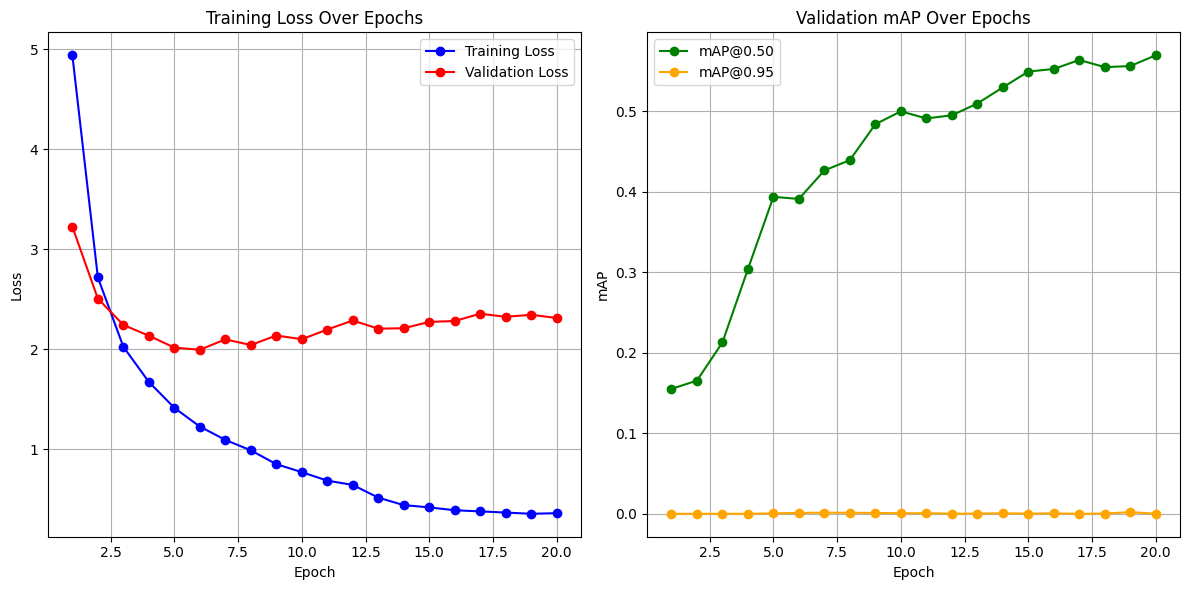

In [31]:
# Plotting
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), fold_train_losses, label="Training Loss", color="blue", marker="o")
plt.plot(range(1, num_epochs + 1), fold_val_losses, label="Validation Loss", color="red", marker="o")
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

# Plot validation mAP
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), fold_val_map_50, label="mAP@0.50", color="green", marker="o")
plt.plot(range(1, num_epochs + 1), fold_val_map_95, label="mAP@0.95", color="orange", marker="o")
plt.title("Validation mAP Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("mAP")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [32]:
# Final Evaluation on Test Set
test_map, ap_per_class = evaluate_model(ssd_model, test_loader, device, class_names, iou_thresholds=[0.5, 0.95])

# Prepare data for tables
map_table = [["Metric", "Value"]]
for key, value in test_map.items():
    map_table.append([key, f"{value:.4f}"])
map_table_str = tabulate(map_table, headers="firstrow", tablefmt="fancy_grid")

class_ap_table_50 = [["Class", "AP"]]
class_ap_table_50.extend(
    [[class_name, f"{ap:.4f}"] for class_name, ap in ap_per_class["IoU 0.50"].items()]
)
class_ap_table_50_str = tabulate(class_ap_table_50, headers="firstrow", tablefmt="fancy_grid")

class_ap_table_95 = [["Class", "AP"]]
class_ap_table_95.extend(
    [[class_name, f"{ap:.4f}"] for class_name, ap in ap_per_class["IoU 0.95"].items()]
)
class_ap_table_95_str = tabulate(class_ap_table_95, headers="firstrow", tablefmt="fancy_grid")

# Combine tables
combined_tables = format_tables_side_by_side(class_ap_table_50_str, class_ap_table_95_str, map_table_str)

# Print results
print("\n" + "=" * 75)
print("Final Test Results")
print("=" * 75)
print(combined_tables)
print("\n" + "=" * 75 + "\n")



Final Test Results
╒═══════════╤════════╕    ╒═══════════╤════════╕    ╒══════════╤═════════╕
│ Class     │     AP │    │ Class     │     AP │    │ Metric   │   Value │
╞═══════════╪════════╡    ╞═══════════╪════════╡    ╞══════════╪═════════╡
│ Cardboard │ 0.6538 │    │ Cardboard │ 0.0238 │    │ mAP@0.50 │  0.6525 │
├───────────┼────────┤    ├───────────┼────────┤    ├──────────┼─────────┤
│ E-waste   │ 0.7108 │    │ E-waste   │ 0.0086 │    │ mAP@0.95 │  0.0217 │
├───────────┼────────┤    ├───────────┼────────┤    ╘══════════╧═════════╛
│ Fabric    │ 0.7288 │    │ Fabric    │ 0.0307 │    
├───────────┼────────┤    ├───────────┼────────┤    
│ Metal     │ 0.8    │    │ Metal     │ 0.0056 │    
├───────────┼────────┤    ├───────────┼────────┤    
│ Organic   │ 0.6527 │    │ Organic   │ 0.0379 │    
├───────────┼────────┤    ├───────────┼────────┤    
│ Paper     │ 0.8278 │    │ Paper     │ 0.0177 │    
├───────────┼────────┤    ├───────────┼────────┤    
│ Plastic   │ 0.8457 │    │ Pla

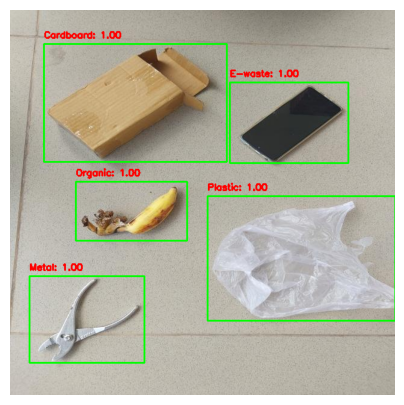

In [44]:
# Define Preprocessing Transformations
test_transform = A.Compose(
    [
        A.Resize(300, 300),  # Ensure this matches the model's expected input size
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

# Function to Load and Preprocess an Image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_height, original_width = image.shape[:2]
    transformed = test_transform(image=image)
    return (
        transformed["image"],  # Preprocessed tensor
        image,  # Original image (RGB)
        original_width,
        original_height,
    )

# Function to Perform Inference
def predict_and_visualize(model, image_path, class_names, device, conf_threshold=0.5):
    # Preprocess the image
    input_tensor, original_image, original_width, original_height = preprocess_image(image_path)
    input_tensor = input_tensor.unsqueeze(0).to(device)  # Add batch dimension

    # Perform inference
    model.eval()
    with torch.no_grad():
        predictions = model(input_tensor)[0]

    # Postprocess predictions
    boxes = predictions["boxes"].cpu().numpy()
    labels = predictions["labels"].cpu().numpy()
    scores = predictions["scores"].cpu().numpy()

    # Filter predictions by confidence threshold
    filtered_indices = scores >= conf_threshold
    boxes = boxes[filtered_indices]
    labels = labels[filtered_indices]
    scores = scores[filtered_indices]

    # Scale bounding boxes back to the original image size
    input_size = 300  # Matches the size used in test_transform
    scale_x = original_width / input_size
    scale_y = original_height / input_size
    boxes = [
        [box[0] * scale_x, box[1] * scale_y, box[2] * scale_x, box[3] * scale_y]
        for box in boxes
    ]

    # Visualize the results
    for box, label, score in zip(boxes, labels, scores):
        x_min, y_min, x_max, y_max = box
        cv2.rectangle(
            original_image,
            (int(x_min), int(y_min)),
            (int(x_max), int(y_max)),
            color=(0, 255, 0),
            thickness=2,
        )
        label_text = f"{class_names[label]}: {score:.2f}"
        cv2.putText(
            original_image,
            label_text,
            (int(x_min), int(y_min) - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (255, 0, 0),
            2,
        )

    # Show the image
    plt.figure(figsize=(5, 5))
    plt.imshow(original_image)
    plt.axis("off")
    plt.show()


# Define Paths and Classes
custom_image_path1 = "/content/10_jpg.rf.3bab97694a3410455f2138e4e9dcc34e.jpg"
# custom_image_path2 = "/content/104_jpg.rf.b7946ce64e4884f67bcf87419dabb70d.jpg"
# custom_image_path3 = "/content/147_jpg.rf.9235cea742f8bc2da2f911b97ae6570d.jpg"
# custom_image_path4 = "/content/247_jpg.rf.f8e8a29ff52d3905496b7ab172746f0c.jpg"
# Load the Trained Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ssd_model.eval()  # Ensure model is in evaluation mode
ssd_model.to(device)

# Predict and Visualize
predict_and_visualize(ssd_model, custom_image_path1, class_names, device, conf_threshold=0.5)
# predict_and_visualize(ssd_model, custom_image_path2, class_names, device, conf_threshold=0.5)
# predict_and_visualize(ssd_model, custom_image_path3, class_names, device, conf_threshold=0.5)
# predict_and_visualize(ssd_model, custom_image_path4, class_names, device, conf_threshold=0.5)
